In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Step 2: Load and Preprocess MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 910824.55it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135085.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272103.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3220714.92it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Step 3: Define the CGAN Architecture with Linear Layers
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.img_shape = img_shape

    def forward(self, img, labels):
        label_embeddings = self.label_embedding(labels)
        label_embeddings = label_embeddings.view(label_embeddings.size(0), -1)
        d_in = torch.cat((img.view(img.size(0), -1), label_embeddings), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
# Step 4: Define Loss Function and Optimizers
adversarial_loss = nn.BCELoss()
latent_dim = 128
num_classes = 10
img_shape = (1, 28, 28)

generator = Generator(latent_dim, num_classes, img_shape)
discriminator = Discriminator(num_classes, img_shape)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0003, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
# Step 5: Train the CGAN
def train(generator, discriminator, trainloader, epochs=100):
    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(trainloader):
            batch_size = imgs.size(0)
            valid = torch.ones(batch_size, 1, requires_grad=False)
            fake = torch.zeros(batch_size, 1, requires_grad=False)
            real_imgs = imgs
            labels = labels

            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim)
            gen_labels = torch.randint(0, num_classes, (batch_size,))
            gen_imgs = generator(z, gen_labels)
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)
            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()
            real_pred = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(real_pred, valid)

            fake_pred = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(fake_pred, fake)

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            if i % 100 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [Batch {i+100}/{len(trainloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Training the CGAN
train(generator, discriminator, trainloader, epochs=15)


[Epoch 1/15] [Batch 100/600] [D loss: 0.6904008388519287] [G loss: 0.7292245626449585]
[Epoch 1/15] [Batch 200/600] [D loss: 0.36128494143486023] [G loss: 1.2166883945465088]
[Epoch 1/15] [Batch 300/600] [D loss: 0.4398132264614105] [G loss: 1.1246973276138306]
[Epoch 1/15] [Batch 400/600] [D loss: 0.5552250742912292] [G loss: 0.46780136227607727]
[Epoch 1/15] [Batch 500/600] [D loss: 0.31501543521881104] [G loss: 1.1462973356246948]
[Epoch 1/15] [Batch 600/600] [D loss: 0.1204216480255127] [G loss: 1.9157824516296387]
[Epoch 2/15] [Batch 100/600] [D loss: 0.1097920686006546] [G loss: 2.1812076568603516]
[Epoch 2/15] [Batch 200/600] [D loss: 0.12400808930397034] [G loss: 2.0356812477111816]
[Epoch 2/15] [Batch 300/600] [D loss: 0.15244516730308533] [G loss: 3.6279773712158203]
[Epoch 2/15] [Batch 400/600] [D loss: 0.1883886158466339] [G loss: 4.274394512176514]
[Epoch 2/15] [Batch 500/600] [D loss: 0.5389400720596313] [G loss: 4.831380367279053]
[Epoch 2/15] [Batch 600/600] [D loss: 0.

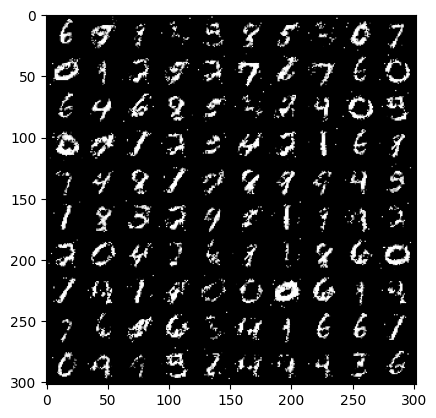

In [ ]:
# Step 6: Generate and Display Fake Images
def generate_images(generator, num_images):
    z = torch.randn(num_images, latent_dim)
    labels = torch.randint(0, num_classes, (num_images,))
    gen_imgs = generator(z, labels)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    grid = torchvision.utils.make_grid(gen_imgs, nrow=10)
    plt.imshow(grid.permute(1, 2, 0).detach().numpy())
    plt.show()

generate_images(generator, 100)



In [ ]:
# Step 7: Replace Linear Layers with Convolutional Layers
class ConvGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels=1):
        super(ConvGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, img_channels, 3, stride=2, padding=1),
            nn.Tanh(),
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        labels = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        noise = noise.unsqueeze(2).unsqueeze(3)
        input = torch.cat([noise, labels], 1)
        return self.conv_blocks(input)

In [ ]:
class ConvDiscriminator(nn.Module):
    def __init__(self, num_classes, img_channels=1):
        super(ConvDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(512, 1, 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        labels = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        labels = labels.expand(labels.size(0), labels.size(1), img.size(2), img.size(3))
        d_in = torch.cat((img, labels), 1)
        validity = self.model(d_in)
        return validity.view(validity.size(0), -1)

In [ ]:
conv_generator = ConvGenerator(latent_dim, num_classes)
conv_discriminator = ConvDiscriminator(num_classes)

optimizer_G = optim.Adam(conv_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(conv_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))



In [ ]:
device=torch.device("cpu")
criterion = nn.BCELoss()
num_epochs = 10
for epoch in range(num_epochs):
    for real, labels in trainloader:
        batch_size = real.size(0)
        real = real.to(device)
        labels = labels.to(device)

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake = conv_generator(noise, fake_labels)

        D_real = conv_discriminator(real, labels)
        lossD_real = criterion(D_real, torch.ones_like(D_real))
        D_fake = conv_discriminator(fake.detach(), fake_labels)
        lossD_fake = criterion(D_fake, torch.zeros_like(D_fake))
        lossD = (lossD_real + lossD_fake) / 2

        optimizer_D.zero_grad()
        lossD.backward()
        optimizer_D.step()

        output = conv_discriminator(fake, fake_labels)
        lossG = criterion(output, torch.ones_like(output))

        optimizer_G.zero_grad()
        lossG.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

In [ ]:
def generate_and_display_conv(generator, num_images=10):
    generator.eval()
    noise = torch.randn(num_images, z_dim).to(device)
    labels = torch.randint(0, 10, (num_images,)).to(device)
    with torch.no_grad():
        fake_images = generator(noise, labels).cpu()
    grid = torchvision.utils.make_grid(fake_images, nrow=10, normalize=True)
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

generate_and_display_conv(conv_generator)